In [40]:
import numpy as np
import pandas as pd
import os
import cv2
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [4]:
df = pd.read_csv("balls/balls.csv")

In [5]:
len(df)

3895

In [9]:
df["data set"].value_counts()

train    3595
test      150
valid     150
Name: data set, dtype: int64

In [8]:
dfs = df["data set"].value_counts()

values = dfs.values 
names = dfs.index

fig = px.pie(values=values, names=names, hole=0.5)
fig.show()

In [67]:
train_dir = "balls/train"
valid_dir = "balls/valid"
test_dir = "balls/test"

num_classes = 30

In [68]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1. / 255
)

validation_datagen = ImageDataGenerator(
    rescale=1. / 255
)

In [69]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 3595 images belonging to 30 classes.
Found 150 images belonging to 30 classes.
Found 150 images belonging to 30 classes.


In [70]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [71]:
for layer in base_model.layers:
    layer.trainable = False

In [72]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [73]:
model = Model(inputs=base_model.input, outputs=predictions)

In [74]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [75]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

Epoch 1/10
112/112 [==============================] - 26s 227ms/step - loss: 0.5806 - accuracy: 0.8456 - val_loss: 0.1885 - val_accuracy: 0.9297
Epoch 2/10
112/112 [==============================] - 26s 229ms/step - loss: 0.1254 - accuracy: 0.9630 - val_loss: 0.2938 - val_accuracy: 0.9141
Epoch 3/10
112/112 [==============================] - 28s 247ms/step - loss: 0.1095 - accuracy: 0.9680 - val_loss: 0.2597 - val_accuracy: 0.9062
Epoch 4/10
112/112 [==============================] - 30s 263ms/step - loss: 0.0539 - accuracy: 0.9829 - val_loss: 0.2261 - val_accuracy: 0.9531
Epoch 5/10
112/112 [==============================] - 30s 264ms/step - loss: 0.0461 - accuracy: 0.9860 - val_loss: 0.2218 - val_accuracy: 0.9688
Epoch 6/10
112/112 [==============================] - 31s 273ms/step - loss: 0.0393 - accuracy: 0.9882 - val_loss: 0.4022 - val_accuracy: 0.9219
Epoch 7/10
112/112 [==============================] - 31s 276ms/step - loss: 0.0298 - accuracy: 0.9910 - val_loss: 0.1918 - val_ac

In [76]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.580617,0.845636,0.188544,0.929688
1,0.125374,0.962953,0.293784,0.914062
2,0.109527,0.968004,0.259721,0.906250
3,0.053893,0.982880,0.226088,0.953125
4,0.046143,0.985967,0.221797,0.968750


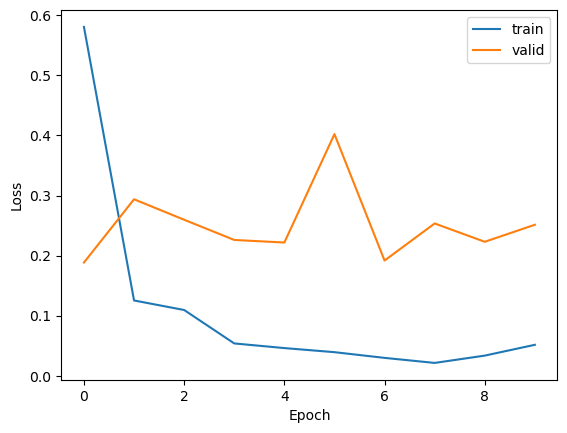

In [77]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "valid"])
plt.show()

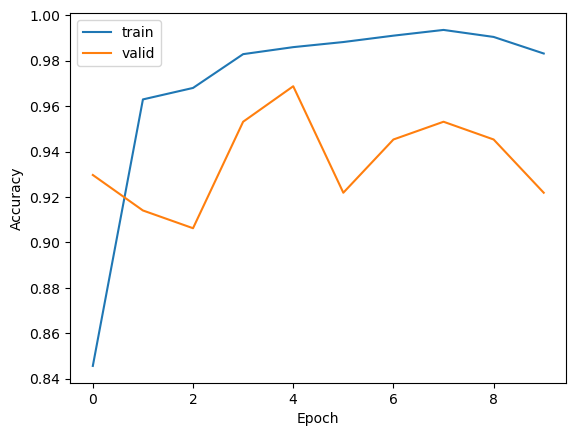

In [78]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "valid"])
plt.show()

In [79]:
preds = model.predict(test_generator)

5/5 [==============================] - 1s 196ms/step


In [80]:
model.save("Balls.h5")

In [81]:
y_pred = np.argmax(preds, axis=1)
y_pred_classes = dict((v, k) for k, v in test_generator.class_indices.items())
y_pred = list(map(lambda x: y_pred_classes[x], y_pred))

In [88]:
y_test = test_generator.classes
y_test = list(map(lambda x: y_pred_classes[x], y_test))

In [89]:
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

         baseball       1.00      1.00      1.00         5
       basketball       0.80      0.80      0.80         5
       beachballs       0.83      1.00      0.91         5
    billiard ball       1.00      1.00      1.00         5
     bowling ball       0.62      1.00      0.77         5
            brass       1.00      0.80      0.89         5
      buckeyballs       1.00      1.00      1.00         5
      cannon ball       1.00      1.00      1.00         5
    chrochet ball       1.00      0.60      0.75         5
     cricket ball       0.83      1.00      0.91         5
     crystal ball       1.00      0.80      0.89         5
         eyeballs       1.00      1.00      1.00         5
         football       0.83      1.00      0.91         5
        golf ball       1.00      1.00      1.00         5
           marble       1.00      0.80      0.89         5
        meat ball       1.00      0.60      0.75       